# Analyzing LA Fire Regions Using NASA's PACE OCI Satellite Data

### Imports and Set Up

In [5]:
import os
import re
import numpy as np
import earthaccess
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

c:\Users\katel\OneDrive\Desktop\pace-wildlife\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Set the curent working directory to \pace-wildlife
os.chdir("..")
print("Current directory:", os.getcwd())
from src.downloader.pace_data_downloader import PaceDataDownloader

Current directory: c:\Users\katel\OneDrive\Desktop\pace-wildlife


### Downloading PACE Data

In [ ]:
# Download the data if not already downloaded
auth = earthaccess.login(persist=True)

dates = ("2024-12-22", "2025-02-28")
pacific_pal_bbox = (-118.75, 33.90, -118.45, 34.15)
downloader = PaceDataDownloader(bounding_box=pacific_pal_bbox, time_span=dates)

# Download PACE OCI data:
downloader.download_data("PACE_OCI_L2_BGC_NRT", max_count=100, version=3.0)
downloader.download_data("PACE_OCI_L2_AOP_NRT", max_count=100)
downloader.download_data("PACE_OCI_L2_LANDVI_NRT", max_count=100)

Found 70 results
[Collection: {'ShortName': 'PACE_OCI_L2_BGC_NRT', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 39.31665, 'Longitude': -103.36293}, {'Latitude': 33.74697, 'Longitude': -132.71567}, {'Latitude': 16.29817, 'Longitude': -126.16123}, {'Latitude': 21.43283, 'Longitude': -101.34579}, {'Latitude': 39.31665, 'Longitude': -103.36293}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-04T20:23:21Z', 'EndingDateTime': '2025-01-04T20:28:21Z'}}
Size(MB): 17.646299362182617
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250104T202321.L2.OC_BGC.V3_0.NRT.nc'], Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_BGC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 39.52534, 'Longitude': -112.04425}, {'Latitude': 33.94631, 'Longitude': -141.48352}, {'Latitude': 16.50347,

QUEUEING TASKS | : 100%|██████████| 70/70 [00:00<00:00, 1085.60it/s]
PROCESSING TASKS | : 100%|██████████| 70/70 [00:00<?, ?it/s]
COLLECTING RESULTS | : 100%|██████████| 70/70 [00:00<?, ?it/s]

['data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250104T202321.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250105T205806.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250106T195426.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250107T202910.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250108T210354.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250109T200019.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250110T203503.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250111T193627.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250111T210946.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250112T200611.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250113T204049.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250114T193713.L2.OC_BGC.V3_0.NRT.nc', 'data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250114T211532.L2.OC_BGC.V3_0.NRT.nc'

Found 70 results
[Collection: {'ShortName': 'PACE_OCI_L2_AOP_NRT', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 39.31665, 'Longitude': -103.36293}, {'Latitude': 33.74697, 'Longitude': -132.71567}, {'Latitude': 16.29817, 'Longitude': -126.16123}, {'Latitude': 21.43283, 'Longitude': -101.34579}, {'Latitude': 39.31665, 'Longitude': -103.36293}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-04T20:23:21Z', 'EndingDateTime': '2025-01-04T20:28:21Z'}}
Size(MB): 232.30857753753662
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250104T202321.L2.OC_AOP.V3_0.NRT.nc'], Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_AOP_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 39.52534, 'Longitude': -112.04425}, {'Latitude': 33.94631, 'Longitude': -141.48352}, {'Latitude': 16.50347,

QUEUEING TASKS | : 100%|██████████| 70/70 [00:00<00:00, 10185.65it/s]
PROCESSING TASKS | : 100%|██████████| 70/70 [00:00<?, ?it/s]
COLLECTING RESULTS | : 100%|██████████| 70/70 [00:00<?, ?it/s]

['data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250104T202321.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250105T205806.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250106T195426.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250107T202910.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250108T210354.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250109T200019.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250110T203503.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250111T193627.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250111T210946.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250112T200611.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250113T204049.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250114T193713.L2.OC_AOP.V3_0.NRT.nc', 'data\\PACE_OCI_L2_AOP_NRT\\PACE_OCI.20250114T211532.L2.OC_AOP.V3_0.NRT.nc'

Found 70 results
[Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_LANDVI_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 39.31665, 'Longitude': -103.36293}, {'Latitude': 33.74697, 'Longitude': -132.71567}, {'Latitude': 16.29817, 'Longitude': -126.16123}, {'Latitude': 21.43283, 'Longitude': -101.34579}, {'Latitude': 39.31665, 'Longitude': -103.36293}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-01-04T20:28:21Z', 'BeginningDateTime': '2025-01-04T20:23:21Z'}}
Size(MB): 31.60716152191162
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250104T202321.L2.LANDVI.V3_0.NRT.nc'], Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_LANDVI_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 39.52534, 'Longitude': -112.04425}, {'Latitude': 33.94631, 'Longitude': -141.48352}, {'Latitude': 16.5

QUEUEING TASKS | : 100%|██████████| 70/70 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|██████████| 70/70 [00:00<00:00, 109145.46it/s]
COLLECTING RESULTS | : 100%|██████████| 70/70 [00:00<00:00, 18284.94it/s]

['data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250104T202321.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250105T205806.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250106T195426.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250107T202910.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250108T210354.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250109T200019.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250110T203503.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250111T193627.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250111T210946.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250112T200611.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250113T204049.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI.20250114T193713.L2.LANDVI.V3_0.NRT.nc', 'data\\PACE_OCI_L2_LANDVI_NRT\\PACE_OCI

### Functions to Load Data

In [ ]:
def load_dataset_with_vars(file_path, variables_of_interest) -> 'xr.Dataset':
    """This function loads a single .nc data file into an xarray with the variables of interest."""
    # Open the dataset with the group containing the data variables
    ds_data = xr.open_dataset(file_path, group="geophysical_data")

    # Select only the variables of interest
    selected_vars = ds_data[variables_of_interest]

    # Open the dataset with the navigation data (for lat/lon)
    ds_nav = xr.open_dataset(file_path, group="navigation_data")
    ds_nav = ds_nav.set_coords(("longitude", "latitude"))

    # Merge selected variables with the coordinates
    merged_ds = xr.merge([selected_vars, ds_nav.coords])
    print(merged_ds)
    return merged_ds

In [6]:
test_file = Path("data/PACE_OCI_L2_BGC_NRT/PACE_OCI.20250104T202321.L2.OC_BGC.V3_0.NRT.nc")
load_dataset_with_vars(test_file, ["carbon_phyto", "chlor_a", "poc"])

<xarray.Dataset> Size: 44MB
Dimensions:       (number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 9MB ...
    latitude      (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    carbon_phyto  (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a       (number_of_lines, pixels_per_line) float32 9MB ...
    poc           (number_of_lines, pixels_per_line) float32 9MB ...


<xarray.Dataset> Size: 44MB
Dimensions:       (number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 9MB ...
    latitude      (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    carbon_phyto  (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a       (number_of_lines, pixels_per_line) float32 9MB ...
    poc           (number_of_lines, pixels_per_line) float32 9MB ...

In [7]:
def extract_time_from_filename(filename):
    # Example: '...20240509T1230Z.nc' → datetime object
    match = re.search(r'(\d{8}T\d{4})', filename)
    if match:
        return datetime.strptime(match.group(1), '%Y%m%dT%H%M')
    else:
        raise ValueError(f"Timestamp not found in {filename}")

In [8]:
def load_merged_dataset(data_dir, variables_of_interest) -> 'xr.Dataset':
    """
    Loads .nc files from a data directory for an instrument and area of interest
    and extracts the coordinates and variables of interest. Merges all the data together
    with a new time coordinate and returns an xarray dataset.
    """
    datasets = []
    for file_path in data_dir.iterdir():
        # Open data variables from geophysical group
        ds_data = xr.open_dataset(file_path, group="geophysical_data")
        selected_vars = ds_data[variables_of_interest]

        # Open coordinates from navigation group
        ds_nav = xr.open_dataset(file_path, group="navigation_data")
        ds_nav = ds_nav.set_coords(("longitude", "latitude"))

        # Merge variables with coordinates
        merged = xr.merge([selected_vars, ds_nav.coords])

        time_value = extract_time_from_filename(file_path.stem)
        merged = merged.expand_dims(time=[time_value])

        datasets.append(merged)

    min_lines = min(ds.sizes['number_of_lines'] for ds in datasets)

    datasets_trimmed = [
        ds.isel(number_of_lines=slice(0, min_lines)) for ds in datasets
    ]

    # Concatenate along the time dimension
    combined = xr.concat(datasets_trimmed, dim="time")
    return combined

In [9]:
aop_dir = Path("data/PACE_OCI_L2_AOP_NRT")
bgc_dir = Path("data/PACE_OCI_L2_BGC_NRT")
landvi_dir = Path("data/PACE_OCI_L2_LANDVI_NRT")

### BGC (Biogeochemical) Data - Chlorophyll, Phytoplankton, Carbon

In [18]:
bgc_merged_ds = load_merged_dataset(bgc_dir, ["carbon_phyto", "chlor_a", "poc"])
bgc_merged_ds

<xarray.Dataset> Size: 3GB
Dimensions:       (time: 70, number_of_lines: 1709, pixels_per_line: 1272)
Coordinates:
  * time          (time) datetime64[ns] 560B 2025-01-04T20:23:00 ... 2025-02-...
    longitude     (time, number_of_lines, pixels_per_line) float32 609MB -126...
    latitude      (time, number_of_lines, pixels_per_line) float32 609MB 16.3...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    carbon_phyto  (time, number_of_lines, pixels_per_line) float32 609MB nan ...
    chlor_a       (time, number_of_lines, pixels_per_line) float32 609MB nan ...
    poc           (time, number_of_lines, pixels_per_line) float32 609MB nan ...

In [ ]:
# TODO: show some plots of the variables

In [19]:
def summarize_variable_in_bbox(ds, var_name, bbox):
    lon_min, lat_min, lon_max, lat_max = bbox

    times = ds['time'].values
    results = []

    for t in range(len(times)):
        # Select the time slice
        var_slice = ds[var_name].isel(time=t)
        lat = ds['latitude'].isel(time=t).values
        lon = ds['longitude'].isel(time=t).values

        # Create bounding box mask
        mask = (
            (lon >= lon_min) & (lon <= lon_max) &
            (lat >= lat_min) & (lat <= lat_max)
        )

        # Apply mask
        data_vals = var_slice.values[mask]

        # Compute stats
        valid_pixels = np.count_nonzero(~np.isnan(data_vals))
        nan_pixels = np.count_nonzero(np.isnan(data_vals))
        mean_val = np.nanmean(data_vals) if valid_pixels > 0 else np.nan

        results.append({
            "time": str(times[t]),
            "mean_value": mean_val,
            "valid_pixels": valid_pixels,
            "nan_pixels": nan_pixels
        })

    return results

avg_pixel_vals = summarize_variable_in_bbox(bgc_merged_ds, "chlor_a", (-118.75, 33.90, -118.45, 34.15))
avg_pixel_vals

[{'time': '2025-01-04T20:23:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 556},
 {'time': '2025-01-05T20:58:00.000000000',
  'mean_value': np.float32(1.6612492),
  'valid_pixels': 6,
  'nan_pixels': 262},
 {'time': '2025-01-06T19:54:00.000000000',
  'mean_value': np.float32(9.239508),
  'valid_pixels': 112,
  'nan_pixels': 130},
 {'time': '2025-01-07T20:29:00.000000000',
  'mean_value': np.float32(4.5048604),
  'valid_pixels': 152,
  'nan_pixels': 412},
 {'time': '2025-01-08T21:03:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 214},
 {'time': '2025-01-09T20:00:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 299},
 {'time': '2025-01-10T20:35:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 531},
 {'time': '2025-01-11T19:36:00.000000000',
  'mean_value': nan,
  'valid_pixels': 0,
  'nan_pixels': 104},
 {'time': '2025-01-11T21:09:00.000000000',
  'mean_value': np.float32(1.8831673),
  'va

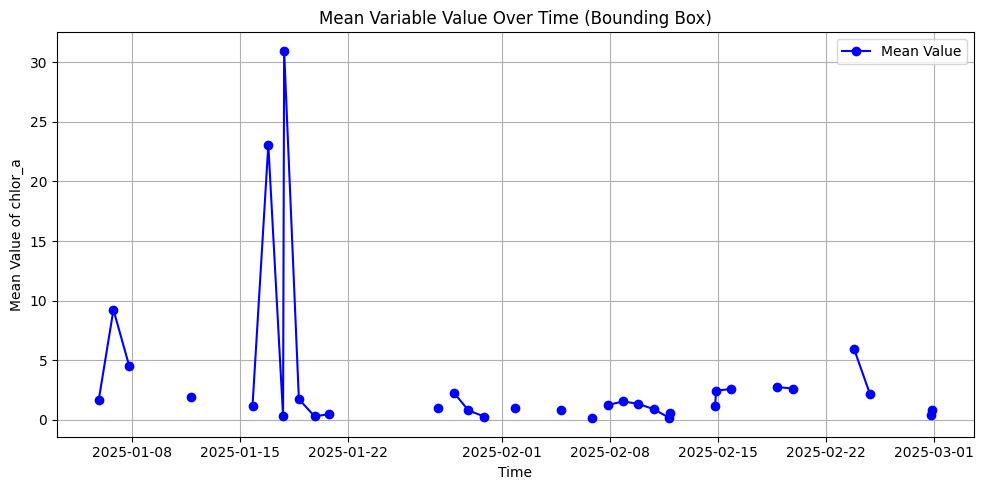

In [20]:
df = pd.DataFrame(avg_pixel_vals)

df['time'] = pd.to_datetime(df['time'])

# Sort by time (optional)
df = df.sort_values('time')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['mean_value'], marker='o', linestyle='-', color='blue', label='Mean Value')
plt.xlabel('Time')
plt.ylabel('Mean Value of chlor_a')
plt.title('Mean Variable Value Over Time (Bounding Box)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

There are a lot of missing variables, but it seems that there are large spikes from Jan 15 to Jan 22, which is about a week after the fires started. However, there is a bit of fluctuation between the measurements of different days in that time range, which suggests missing or skewed data affecting the measurements.

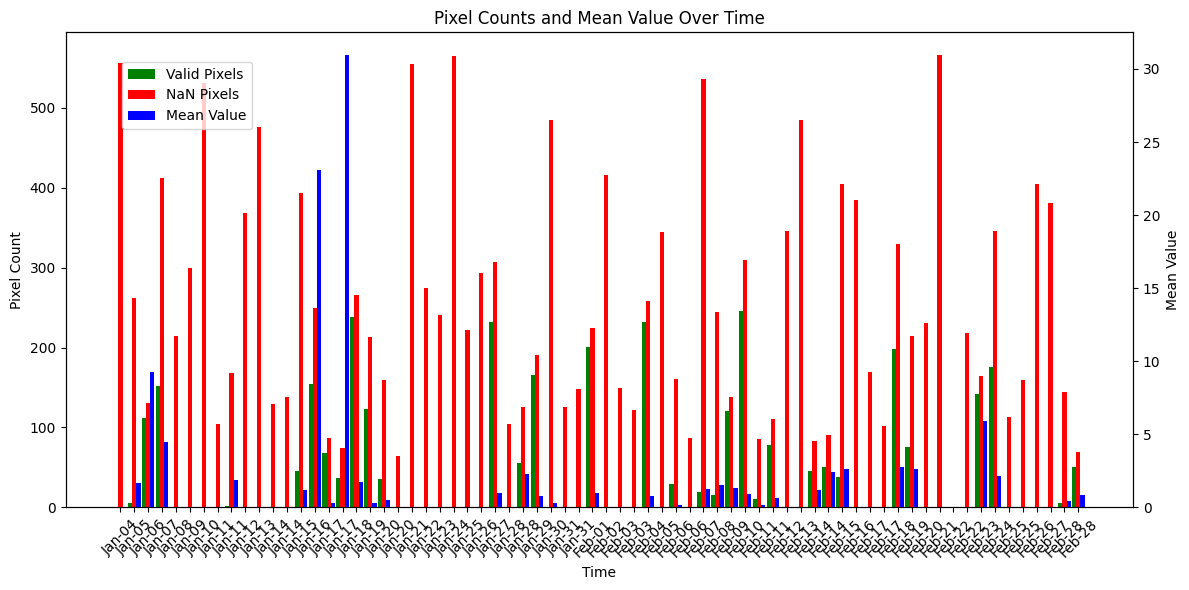

In [21]:
# Set figure and width of bars
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.3
x = np.arange(len(df))

# Plot valid and nan pixels
ax1.bar(x - bar_width, df['valid_pixels'], width=bar_width, label='Valid Pixels', color='green')
ax1.bar(x, df['nan_pixels'], width=bar_width, label='NaN Pixels', color='red')
ax1.set_ylabel('Pixel Count')
ax1.set_xlabel('Time')
ax1.set_xticks(x)
ax1.set_xticklabels(df['time'].dt.strftime('%b-%d'), rotation=45)

# Plot mean value on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(x + bar_width, df['mean_value'], width=bar_width, label='Mean Value', color='blue')
ax2.set_ylabel('Mean Value')

# Legends and layout
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Pixel Counts and Mean Value Over Time')
plt.tight_layout()
plt.show()

In [11]:
def summarize_variables_in_bbox(ds, variable_names, bbox):
    lon_min, lat_min, lon_max, lat_max = bbox
    times = ds['time'].values
    summaries = {var: [] for var in variable_names}

    for t in range(len(times)):
        lat = ds['latitude'].isel(time=t).values
        lon = ds['longitude'].isel(time=t).values

        # Create bounding box mask
        mask = (
            (lon >= lon_min) & (lon <= lon_max) &
            (lat >= lat_min) & (lat <= lat_max)
        )

        for var in variable_names:
            var_slice = ds[var].isel(time=t).values
            data_vals = var_slice[mask]

            valid_pixels = np.count_nonzero(~np.isnan(data_vals))
            nan_pixels = np.count_nonzero(np.isnan(data_vals))
            mean_val = np.nanmean(data_vals) if valid_pixels > 0 else np.nan

            summaries[var].append({
                "time": times[t],
                "mean_value": mean_val,
                "valid_pixels": valid_pixels,
                "nan_pixels": nan_pixels
            })

    return summaries

In [12]:
bgc_summaries = summarize_variables_in_bbox(bgc_merged_ds, ["chlor_a", "carbon_phyto", "poc"], (-118.75, 33.90, -118.45, 34.15))
bgc_summaries

{'chlor_a': [{'time': np.datetime64('2025-01-04T20:23:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 556},
  {'time': np.datetime64('2025-01-05T20:58:00.000000000'),
   'mean_value': np.float32(1.6612492),
   'valid_pixels': 6,
   'nan_pixels': 262},
  {'time': np.datetime64('2025-01-06T19:54:00.000000000'),
   'mean_value': np.float32(9.239508),
   'valid_pixels': 112,
   'nan_pixels': 130},
  {'time': np.datetime64('2025-01-07T20:29:00.000000000'),
   'mean_value': np.float32(4.5048604),
   'valid_pixels': 152,
   'nan_pixels': 412},
  {'time': np.datetime64('2025-01-08T21:03:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 214},
  {'time': np.datetime64('2025-01-09T20:00:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 299},
  {'time': np.datetime64('2025-01-10T20:35:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 531},
  {'time': np.datetime64('2025-01-11T19:36:00.0000

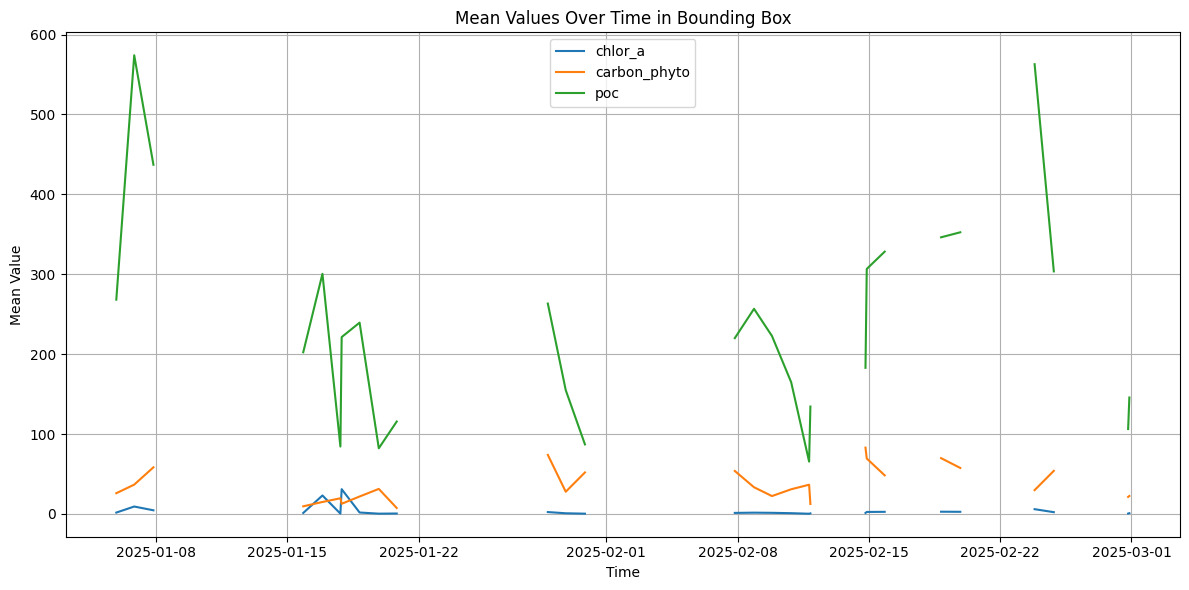

In [13]:
def plot_mean_values(summaries):
    plt.figure(figsize=(12, 6))

    for var_name, records in summaries.items():
        df = pd.DataFrame(records)
        df['time'] = pd.to_datetime(df['time'])
        plt.plot(df['time'], df['mean_value'], label=var_name)

    plt.xlabel("Time")
    plt.ylabel("Mean Value")
    plt.title("Mean Values Over Time in Bounding Box")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mean_values(bgc_summaries)

In [22]:
def apply_transformations(ds, transformations):
    """
    Apply specified transformations to variables in an xarray.Dataset.

    Parameters:
        ds (xarray.Dataset): The dataset to transform.
        transformations (dict): A mapping from variable names to transformation functions.

    Returns:
        xarray.Dataset: A new dataset with transformations applied.
    """
    ds_transformed = ds.copy()
    
    for var_name, func in transformations.items():
        if var_name in ds:
            try:
                ds_transformed[var_name] = func(ds[var_name])
            except Exception as e:
                print(f"Error applying transformation to {var_name}: {e}")
        else:
            print(f"Variable '{var_name}' not found in dataset.")
    
    return ds_transformed

bgc_merged_ds = apply_transformations(bgc_merged_ds, {"chlor_a": np.log, "poc": np.log1p, "carbon_phyto": np.log})

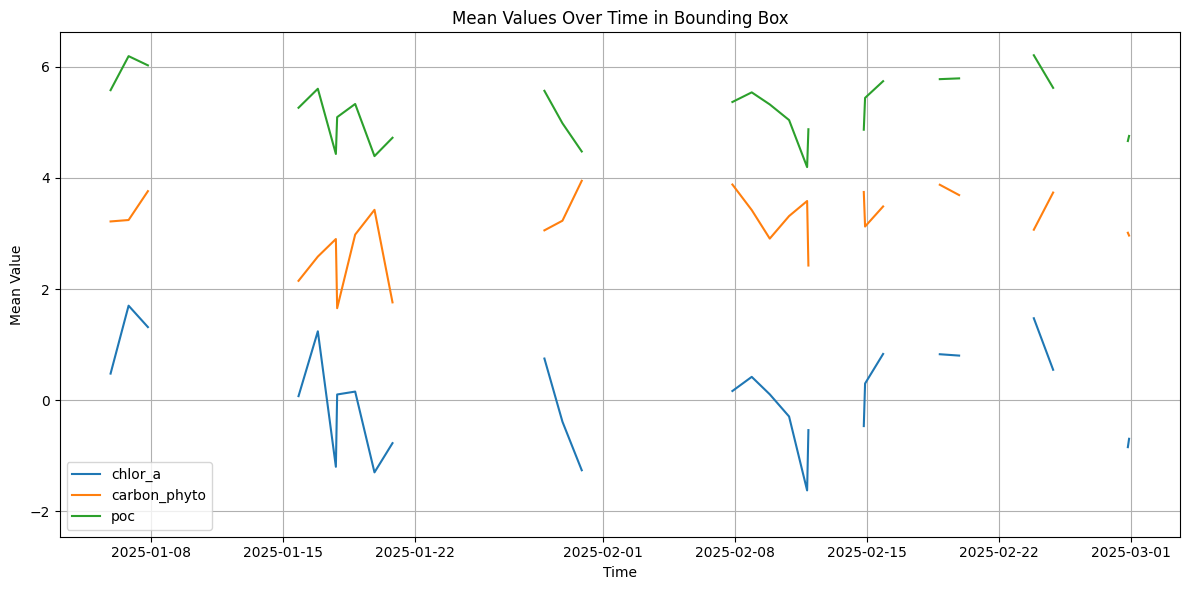

In [23]:
transformed_bgc_summaries = summarize_variables_in_bbox(bgc_merged_ds, ["chlor_a", "carbon_phyto", "poc"], (-118.75, 33.90, -118.45, 34.15))
plot_mean_values(transformed_bgc_summaries)